In [1]:
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [14]:
params = {
    'batch_size':  16,
    'num_workers': 2,
    'device':   'cpu',
    'num_epochs': 4,
    'learning_rate': 0.0001,
    'weight_decay': 5e-4,
}
transform = transforms.ToTensor()
## Train
trainset = torchvision.datasets.MNIST('../data', 
                                      train=True, 
                                      download=True, 
                                      transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=params['batch_size'], 
                                          shuffle=True, 
                                          num_workers=params['num_workers'])
### Test 
testset = torchvision.datasets.MNIST('../data', 
                                     train=False, 
                                     download=True, 
                                     transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=params['batch_size'], 
                                         shuffle=False, 
                                         num_workers=params['num_workers'])

In [15]:
trainloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [16]:
testloader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [17]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

tensor([6, 9, 9, 6, 1, 3, 8, 4, 1, 8, 4, 2, 2, 7, 8, 3])


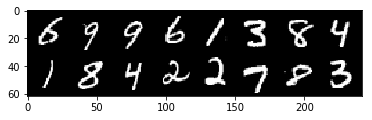

In [18]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)
show_batch(images)

In [19]:
images.view(params['batch_size'], -1).size()[1]

784

In [20]:
## Simple MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(params['batch_size'], -1)))
        y_pred = self.linear2(h_relu)
        return y_pred

In [21]:
model = MLP()
model

MLP(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)

In [507]:
def train(model, trainloader, criterion, optimizer, n_epochs=10):
    for t in range(n_epochs):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels) 
            loss.backward() 
            optimizer.step()

            if not i % 2000:
                print("    --> EPOCH {}, ITER {}, LOSS {}".format(t, i, loss.data.numpy()))

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
train(model, trainloader, criterion, optimizer, n_epochs = params['num_epochs'])

EPOCH 0, ITER 0, LOSS 2.3445932865142822
EPOCH 0, ITER 2000, LOSS 0.2205289900302887
EPOCH 1, ITER 0, LOSS 0.24082089960575104
EPOCH 1, ITER 2000, LOSS 0.13819006085395813
EPOCH 2, ITER 0, LOSS 0.22084903717041016
EPOCH 2, ITER 2000, LOSS 0.1230885237455368
EPOCH 3, ITER 0, LOSS 0.2177715003490448
EPOCH 3, ITER 2000, LOSS 0.1402275413274765


In [25]:
def predict(model, images):
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    return predicted

LABELS: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
PREDICTION:  [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5]


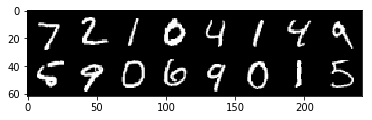

In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print("LABELS: {}".format(labels.numpy()))
print('PREDICTION: ', predict(model, images).numpy())
show_batch(images)

In [27]:
def test(model, testloader):
    correct = 0
    for data in testloader:
        inputs, labels = data
        pred = predict(model, inputs)
        correct += (pred == labels).sum()
    return 100 * correct / len(testset)

In [28]:
print('ACCURACY: {}%'.format(test(model, testloader).numpy()))

ACCURACY: 95%


## Using Weight Pruning

In [464]:
params = {
    'pruning_perc': 85.,
    'batch_size': 16, 
    'test_batch_size': 100,
    'num_epochs': 4,
    'learning_rate': 0.001,
    'weight_decay': 5e-4,
}

In [465]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.register_buffer('mask', mask)
        mask_var = self.get_mask()
        self.weight.data = self.weight.data*mask_var.data
        self.mask_flag = True
    
    def get_mask(self):
        return self.mask.clone().detach().requires_grad_(False)
    
    def forward(self, x):
        if self.mask_flag == True:
            mask_var = self.get_mask()
            weight = self.weight * mask_var
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)

In [466]:
## Simple MLP
class MLP_weight_prunning(nn.Module):
    def __init__(self):
        super(MLP_weight_prunning, self).__init__()
        self.linear1 = MaskedLinear(28*28, 256)
        self.linear2 = MaskedLinear(256, 10)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(params['batch_size'], -1)))
        y_pred = self.linear2(h_relu)
        return y_pred
    def set_masks(self, masks):
    # Should be a less manual way to set masks
    # Leave it for the future
        self.linear1.set_mask(masks[0])
        self.linear2.set_mask(masks[1])

In [467]:
model_2 = MLP_weight_prunning()
print('ACCURACY: {}%'.format(test(model_2, testloader).numpy()))
model_2

ACCURACY: 11%


MLP_weight_prunning(
  (linear1): MaskedLinear(in_features=784, out_features=256, bias=True)
  (linear2): MaskedLinear(in_features=256, out_features=10, bias=True)
)

In [229]:
print(model_2.linear1.weight.data.shape)
model_2.linear1.weight.data

torch.Size([256, 784])


tensor([[ 0.0351, -0.0245, -0.0308,  ..., -0.0335,  0.0011,  0.0050],
        [ 0.0100,  0.0053, -0.0136,  ...,  0.0299, -0.0240, -0.0132],
        [-0.0307, -0.0164, -0.0338,  ..., -0.0074,  0.0133,  0.0300],
        ...,
        [ 0.0234,  0.0052,  0.0059,  ..., -0.0203,  0.0118, -0.0225],
        [ 0.0089, -0.0007, -0.0033,  ...,  0.0308,  0.0101,  0.0013],
        [ 0.0164,  0.0022, -0.0179,  ..., -0.0174,  0.0249, -0.0245]])

In [230]:
np.percentile(model_2.linear1.weight.data.numpy(),90)

0.02852629348635674

In [231]:
print(model_2.linear2.weight.data.shape)
model_2.linear2.weight.data

torch.Size([10, 256])


tensor([[-0.0130,  0.0190, -0.0212,  ..., -0.0004,  0.0405,  0.0344],
        [-0.0181,  0.0259,  0.0526,  ..., -0.0068, -0.0525, -0.0465],
        [ 0.0481, -0.0533,  0.0124,  ..., -0.0127,  0.0248, -0.0228],
        ...,
        [ 0.0155,  0.0536,  0.0338,  ...,  0.0134, -0.0541,  0.0248],
        [-0.0022,  0.0152, -0.0224,  ...,  0.0129, -0.0559,  0.0302],
        [ 0.0618,  0.0288,  0.0431,  ...,  0.0525, -0.0256, -0.0605]])

In [239]:
def weight_prune(model, pruning_perc):
    '''
    Prune pruning_perc% weights globally (not layer-wise)
    arXiv: 1606.09274
    '''    
    all_weights = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
        ## Skip bias layers
            all_weights += list(p.cpu().data.abs().numpy().flatten())
    threshold = np.percentile(np.array(all_weights), pruning_perc)

    # generate mask
    masks = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            pruned_inds = p.data.abs() > threshold
            masks.append(pruned_inds.float())
    return masks

In [508]:
def weight_prune_2(model, pruning_perc): 
    all_masks = []
    for p in model.parameters():
        mask = []
        if len(p.data.size()) != 1:
        ## Skip bias layers
            weights = list(p.cpu().data.abs().numpy().flatten())
            threshold = np.percentile(np.array(weights), pruning_perc)
            pruned_inds = p.data.abs() > threshold
            all_masks.append(pruned_inds.float())
    return all_masks

In [509]:
masks = weight_prune_2(model_2, 10)
masks

[tensor([[1., 1., 1.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 0., 1., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]),
 tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 0.,  ..., 1., 0., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]])]

In [510]:
def count_zeros_percentage(vec):
    return np.count_nonzero(vec.flatten()==0)/vec.flatten().shape[0]

In [511]:
def prune_model(model, pruning_perc):
    mask_prune = weight_prune_2(model, pruning_perc)
    model.set_masks(mask_prune)
    return model

In [512]:
percentile_prune = [10, 20, 30, 50, 70, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]

In [513]:
models_pruned = [prune_model(MLP_weight_prunning(), i) for i in percentile_prune]
optimizer = [optim.Adam(models_pruned[i].parameters(),lr=params['learning_rate']) for i in range(len(percentile_prune))]
losses = [nn.CrossEntropyLoss() for i in range(len(percentile_prune))]

In [514]:
accuracy_prune = []
for i, (model, opt, loss) in enumerate(zip(models_pruned, optimizer, losses)):
    print("Traning Prune {} %".format(percentile_prune[i]))
    train(model, trainloader, loss, opt, n_epochs = params['num_epochs'])
    accuracy = test(model, testloader).numpy()
    accuracy_prune.append(float(accuracy))
    print('    --> TEST ACCURACY: {}%'.format(accuracy))
    print('-'*50)

Traning Prune 10 %
    --> EPOCH 0, ITER 0, LOSS 2.3262152671813965
    --> EPOCH 0, ITER 2000, LOSS 0.02454419434070587
    --> EPOCH 1, ITER 0, LOSS 0.06956109404563904
    --> EPOCH 1, ITER 2000, LOSS 0.1253294050693512
    --> EPOCH 2, ITER 0, LOSS 0.15861955285072327
    --> EPOCH 2, ITER 2000, LOSS 0.10021628439426422
    --> EPOCH 3, ITER 0, LOSS 0.011322751641273499
    --> EPOCH 3, ITER 2000, LOSS 0.0013284385204315186
    --> TEST ACCURACY: 97%
--------------------------------------------------
Traning Prune 20 %
    --> EPOCH 0, ITER 0, LOSS 2.330096960067749
    --> EPOCH 0, ITER 2000, LOSS 0.04885120689868927
    --> EPOCH 1, ITER 0, LOSS 0.014104753732681274
    --> EPOCH 1, ITER 2000, LOSS 0.27286261320114136
    --> EPOCH 2, ITER 0, LOSS 0.01769845187664032
    --> EPOCH 2, ITER 2000, LOSS 0.02326717972755432
    --> EPOCH 3, ITER 0, LOSS 0.0016768276691436768
    --> EPOCH 3, ITER 2000, LOSS 0.005470246076583862
    --> TEST ACCURACY: 97%
------------------------------

In [524]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt

[Text(0, 0.5, 'Test Accuracy %'), Text(0.5, 0, 'Prune %')]

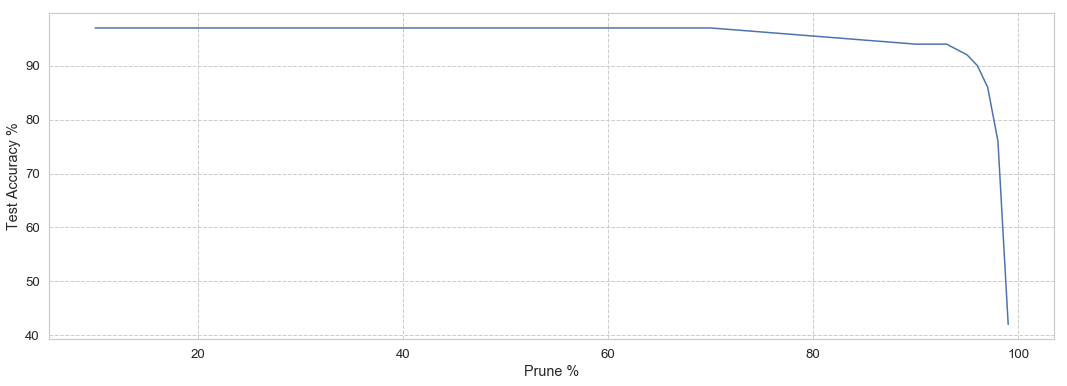

In [531]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.subplots(figsize=(18, 6))
ax = sns.lineplot(percentile_prune, accuracy_prune)
ax.set(xlabel='Prune %', ylabel='Test Accuracy %')

In [501]:
for mod in models_pruned:
    print(count_zeros_percentage(mod.linear1.weight.data.numpy()),count_zeros_percentage(mod.linear2.weight.data.numpy()))
    print('ACCURACY: {}%'.format(test(mod, testloader).numpy()))

0.20000099649234693 0.2
ACCURACY: 97%
0.2999990035076531 0.3
ACCURACY: 97%
0.5 0.5
ACCURACY: 97%
0.7000009964923469 0.7
ACCURACY: 97%
0.8999970105229592 0.9
ACCURACY: 94%
0.9199966119260204 0.919921875
ACCURACY: 94%
0.9399962133290817 0.93984375
ACCURACY: 93%
0.9599958147321429 0.959765625
ACCURACY: 90%
0.9800003985969388 0.9796875
ACCURACY: 78%
0.9900001992984694 0.98984375
ACCURACY: 54%


## References
[1] https://github.com/zepx/pytorch-weight-prune/blob/develop/weight_pruning.py